# Variational Autoencoder in TensorFlow

This code is adapted from the awesome implementations of VAs offered both by Jan Metzen (https://jmetzen.github.io/2015-11-27/vae.html) and Blue Sheffer (https://github.com/bluebs/Variational-Autoencoder/). <3 


### Import and Setup 

We import needed libraries, setup random seeds, and load the dataset. 

In [38]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib.layers import xavier_initializer as xavier_init
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)

In [39]:
# Load MNIST data in a format suited for tensorflow.
# The script input_data is available under this URL:
# https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/examples/tutorials/mnist/input_data.py
mnist = input_data.read_data_sets("data/mnist", one_hot=True)
n_samples = mnist.train.num_examples

Extracting data/mnist/train-images-idx3-ubyte.gz
Extracting data/mnist/train-labels-idx1-ubyte.gz
Extracting data/mnist/t10k-images-idx3-ubyte.gz
Extracting data/mnist/t10k-labels-idx1-ubyte.gz


We now define our Variational Autoencoder object. 

The architecture is as follows, our encoding network takes in the 28x28 image and 


In [40]:
class VariationalAutoencoder(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.
    
    This implementation uses probabilistic encoders and decoders using Gaussian 
    distributions and  realized by multi-layer perceptrons. The VAE can be learned
    end-to-end.
    
    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus, 
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # tf Graph input
        tf.reset_default_graph()
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        # Create autoencoder network
        self.create_network()
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        self.create_loss_optimizer()
        
    
    def create_network(self):
        # Initialize network weights and biases
        network_weights = self.initialize_weights(**self.network_architecture)

        # Use encoder network to determine mean and 
        # (log) variance of Gaussian distribution in latent
        # space
        self.z_mean, self.z_log_sigma_sq = self.encoder_network(network_weights["weights_recog"], 
                                                                network_weights["biases_recog"])

        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, dtype=tf.float32)
        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean,tf.mul(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_reconstr_mean =  self.decoder_network(network_weights["weights_gener"],
                                                     network_weights["biases_gener"])
            
    def initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, 
                                 n_hidden_gener_1,  n_hidden_gener_2, 
                                 n_input, n_z):
        all_weights = dict()

        all_weights['weights_recog'] = {
            'h1': tf.get_variable("e_h1", shape=[n_input,n_hidden_recog_1 ], initializer=xavier_init()),
            'h2': tf.get_variable("e_h2", shape=[n_hidden_recog_1,n_hidden_recog_2 ], initializer=xavier_init()),
            'out_mean': tf.get_variable("e_out_mean_1", shape=[n_hidden_recog_2,n_z ], initializer=xavier_init()),
            'out_log_sigma': tf.get_variable("e_out_log_sigma_1", shape=[n_hidden_recog_2,n_z ], initializer=xavier_init())
        }
        all_weights['biases_recog'] = {
            'b1': tf.get_variable("e_b1", initializer = tf.zeros([n_hidden_recog_1])),
            'b2': tf.get_variable("e_b2", initializer = tf.zeros([n_hidden_recog_2])),
            'out_mean': tf.get_variable("e_out_mean_2", initializer = tf.zeros([n_z])),
            'out_log_sigma': tf.get_variable("e_out_log_sigma_2", initializer = tf.zeros([n_z]))
        }

        all_weights['weights_gener'] = {
            'h1': tf.get_variable("d_h1", shape=[n_z,n_hidden_gener_1 ], initializer=xavier_init()),
            'h2': tf.get_variable("d_h2", shape=[n_hidden_recog_1,n_hidden_gener_2 ], initializer=xavier_init()),
            'out_mean': tf.get_variable("d_out_mean_1", shape=[n_hidden_gener_2,n_input ], initializer=xavier_init()),
            'out_log_sigma': tf.get_variable("d_out_log_sigma_1", shape=[n_hidden_gener_2,n_input ], initializer=xavier_init())
        }
        all_weights['biases_gener'] = {
            'b1': tf.get_variable("d_b1",   initializer = tf.zeros([n_hidden_gener_1])),
            'b2': tf.get_variable("d_b2", initializer = tf.zeros([n_hidden_gener_2])),
            'out_mean': tf.get_variable("d_out_mean_2", initializer = tf.zeros([n_input])),
            'out_log_sigma': tf.get_variable("d_out_log_sigma_2", initializer = tf.zeros([n_input]))
        }
        return all_weights
            
    def encoder_network(self, weights, biases):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])) 
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']), biases['out_mean'])
        
        z_log_sigma_sq = tf.add(tf.matmul(layer_2, weights['out_log_sigma']),  biases['out_log_sigma'])
        return (z_mean, z_log_sigma_sq)

    def decoder_network(self, weights, biases):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])) 
        x_reconstr_mean = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), biases['out_mean']))
        return x_reconstr_mean
            
    def create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution 
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        # Adding 1e-10 to avoid evaluation of log(0.0)
        reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                           + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean),
                           1)
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                                           - tf.square(self.z_mean) 
                                           - tf.exp(self.z_log_sigma_sq), 1)
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)   # average over batch
        # Use ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
   
    def partial_fit(self, sess, X):
        """Train model based on mini-batch of input data.

        Return cost of mini-batch.
        """
        opt, cost = sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x: X})
        return cost
    
    def transform(self, sess, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, sess, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu})
    
    def reconstruct(self, sess, X):
        """ Use VAE to reconstruct given data. """
        return sess.run(self.x_reconstr_mean, 
                             feed_dict={self.x: X})

In general, implementing a VAE in tensorflow is relatively straightforward (in particular since we don not need to code the gradient computation). A bit confusing is potentially that all the logic happens at initialization of the class (where the graph is generated), while the actual sklearn interface methods are very simple one-liners.

We can now define a simple fuction which trains the VAE using mini-batches:

In [41]:
def train(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=5):
    vae = VariationalAutoencoder(network_architecture, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size)
    init = tf.initialize_all_variables()

    # Launch the session
    sess = tf.InteractiveSession()
    sess.run(init)

    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)

            # Fit training using batch data
            cost = vae.partial_fit(sess, batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), 
                  "cost=", "{:.9f}".format(avg_cost))
    return vae, sess

## Illustrating reconstruction quality

We can now train a VAE on MNIST by just specifying the network topology. We start with training a VAE with a 20-dimensional latent space.

In [42]:
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=20)  # dimensionality of latent space

vae, sess  = train(network_architecture, training_epochs=1)

('Epoch:', '0001', 'cost=', '182.417709073')


Based on this we can sample some test inputs and visualize how well the VAE can reconstruct those. In general the VAE does really well.

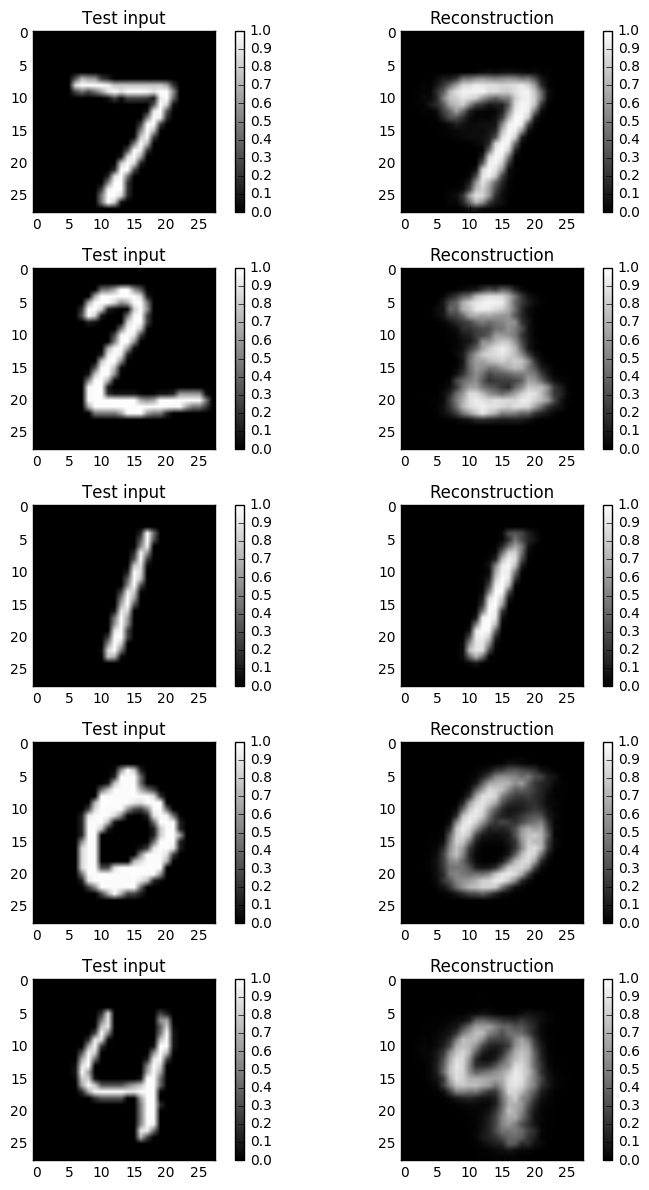

In [43]:
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = vae.reconstruct(sess,x_sample)

plt.figure(figsize=(8, 12))
for i in range(5):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()



## Illustrating latent space

Next, we train a VAE with 2d latent space and illustrates how the encoder (the recognition network) encodes some of the labeled inputs (collapsing the Gaussian distribution in latent space to its mean). This gives us some insights into the structure of the learned manifold (latent space)

In [44]:
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=2)  # dimensionality of latent space

vae_2d, sess = train(network_architecture, training_epochs=1)

('Epoch:', '0001', 'cost=', '190.342198320')


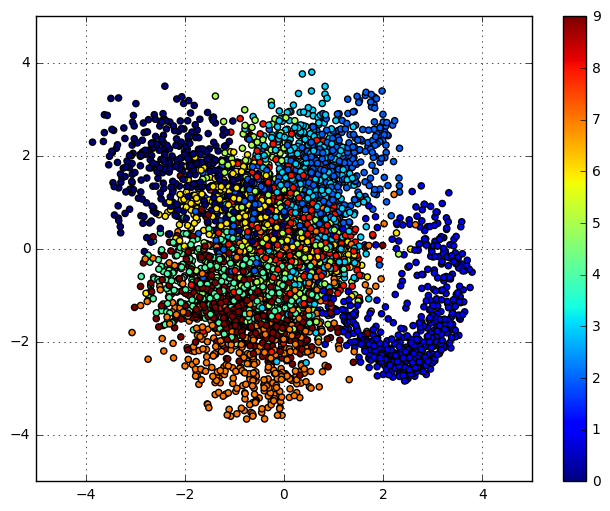

In [45]:
x_sample, y_sample = mnist.test.next_batch(5000)
z_mu = vae_2d.transform(sess, x_sample)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()
plt.grid()

An other way of getting insights into the latent space is to use the generator network to plot reconstrunctions at the positions in the latent space for which they have been generated:

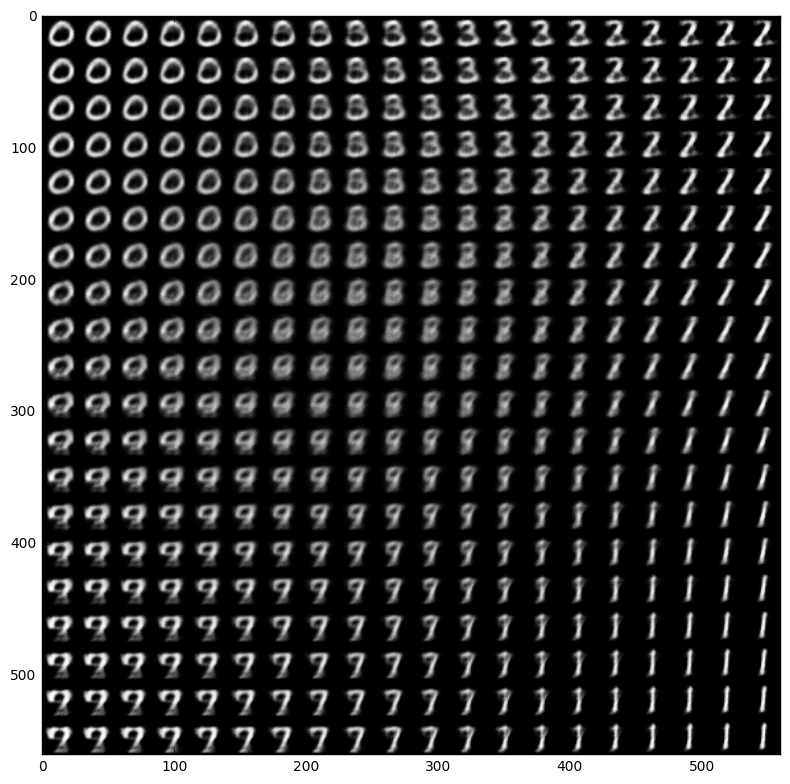

In [46]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae.batch_size)
        x_mean = vae_2d.generate(sess,z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()

## Summary
In summary, tensorflow is well suited to rapidly implement a prototype of machine learning models like VAE. The resulting code could be easily executed on GPUs as well (requiring just that tensorflow with GPU support was installed). VAE allows learning probabilistic encoders and decoders of data in an end-to-end fashion.